In [7]:
# Script to try out implementing tactile information as image
import glob
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
import torchvision.transforms as T 
import torch.nn.functional as F

from abc import ABC
from copy import deepcopy
from torchvision.datasets.folder import default_loader as loader 
from torch.utils import data
from tqdm import tqdm
from omegaconf import DictConfig, OmegaConf

## Tactile Min Images
These are the cells for mini tactile images - aka only the two fingers

In [2]:
root = '/home/irmak/Workspace/Holo-Bot/extracted_data/joystick_2/demonstration_1'
with open(os.path.join(root, 'tactile_indices.pkl'), 'rb') as f:
    tactile_indices = pickle.load(f)
with h5py.File(os.path.join(root, 'touch_sensor_values.h5'), 'r') as f:
    tactile_values = f['sensor_values'][()]


print(tactile_values.shape)

(1326, 15, 16, 3)


In [3]:
class TactileImage:
    def __init__(
        self,
        tactile_value, # (15,16,3) will be the shape
        sensor_indices = [3, 7], # Index and middle tip for now
        size = (4, 8)
    ): 
        desired_tactile_values = tactile_value[sensor_indices]
        num_sensors = len(desired_tactile_values)

        # Reshape the tensor to an image according to the sensor_indices
        tactile_image = torch.FloatTensor(desired_tactile_values)
        tactile_image = tactile_image.reshape((num_sensors, size[0], int(size[1]/num_sensors), -1))
        tactile_image = torch.concat((tactile_image[0], tactile_image[1]), dim=1)
        self.tactile_image = torch.permute(tactile_image, (2,0,1))

        # Resize transform
        self.resize = T.Resize((size[1],size[1]))
        self.tactile_image = self.resize(self.tactile_image)

        # Set up the transforms
        # self.means, self.stds = self.calculate_mean_std(self.tactile_image)


    def calculate_mean_std(self): # This will be used for transforms
        means, stds = [0,0,0], [0,0,0]
        for channel_num in range(self.tactile_image.shape[0]):
            means[channel_num] = self.tactile_image[channel_num,:,:].mean()
            stds[channel_num] = self.tactile_image[channel_num,:,:].std()
        return means, stds

    def plot(self):
        # Map it to 0 and 1 - not super certain this is correct
        min, max = self.tactile_image.min(), self.tactile_image.max()
        img_range = max - min
        img = (self.tactile_image - min) / img_range
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    def apply_aug(self, augmentation):
        self.tactile_image = augmentation(self.tactile_image)

    def get_image(self):
        return self.tactile_image

In [4]:
def get_augmentations(img_means, img_stds):
    tactile_aug = T.Compose([
        T.RandomApply(
            nn.ModuleList([T.RandomResizedCrop((8,8), scale=(.8, 1))]),
            p = 0.5
        ), 
        T.RandomApply(
            nn.ModuleList([T.GaussianBlur((3, 3), (1.0, 2.0))]), 
            p = 0.5
        ),
        T.Normalize(
            mean = img_means, # NOTE: Wasn't this wrong?
            std = img_stds
        )
    ])
    return tactile_aug

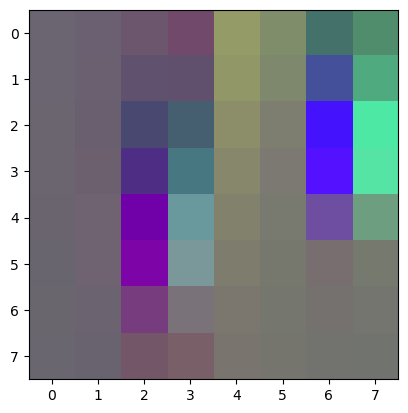

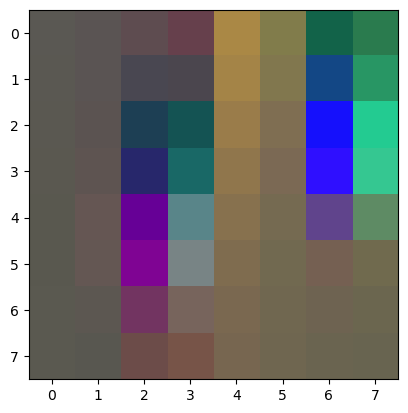

In [6]:
index = 1200
curr_tactile_value = tactile_values[index]
# print(tactile_values[1000][(3,7),:,:].shape)
img = TactileImage(tactile_value=tactile_values[index])
img.plot()
img_means, img_stds = img.calculate_mean_std()
tactile_aug = get_augmentations(img_means, img_stds)
img.apply_aug(tactile_aug)
img.plot()

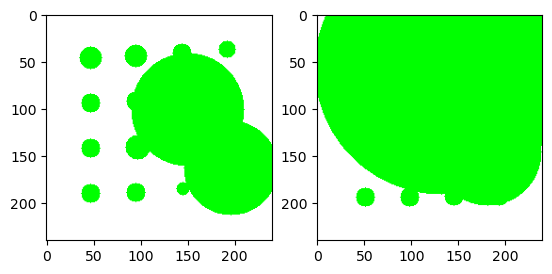

In [7]:
import cv2
import matplotlib.pyplot as plt

def plot_tactile_sensor(ax, sensor_values, use_img=False, img=None):
    # sensor_values: (16, 3) - 3 values for each tactile - x and y represents the position, z represents the pressure on the tactile point
    img_shape = (240, 240, 3) # For one sensor
    blank_image = np.ones(img_shape, np.uint8) * 255
    if use_img == False: 
        img = ax.imshow(blank_image.copy())

    # Set the coordinates for each circle
    tactile_coordinates = []
    for j in range(48, 192+1, 48): # Y
        for i in range(48, 192+1, 48): # X - It goes from top left to bottom right row first 
            tactile_coordinates.append([i,j])

    # Plot the circles 
    for i in range(sensor_values.shape[0]):
        center_coordinates = (
            tactile_coordinates[i][0] + int(sensor_values[i,0]/20), # NOTE: Change this
            tactile_coordinates[i][1] + int(sensor_values[i,1]/20)
        )
        radius = max(10 + int(sensor_values[i,2]/10), 2)
      
        if i == 0:
            frame_axis = cv2.circle(blank_image.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)
        else:
            frame_axis = cv2.circle(frame_axis.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)

    img.set_array(frame_axis)

    return img, frame_axis

fig, axs = plt.subplots(nrows=1, ncols=2)
plot_tactile_sensor(axs[0], curr_tactile_value[3,:,:])
plot_tactile_sensor(axs[1], curr_tactile_value[7,:,:])
plt.show()


In [19]:
# Create the encoder for this image
from tactile_learning.models.custom import PrintSize
class TactileImageEncoder(nn.Module):
    def __init__(
        self,
        in_channels,
        out_dim # Final dimension of the representation
    ):
        super().__init__()
        self.out_dim = out_dim
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=64, kernel_size=2),
            nn.ReLU(),
            # PrintSize(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=2),
            nn.ReLU(),
            # PrintSize(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=2),
            nn.ReLU(),
            # PrintSize()
        )
        self.linear = nn.Linear(in_features=16*5*5, out_features=out_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.model(x)
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = self.linear(x)
        return self.relu(x)


In [17]:
encoder = TactileImageEncoder(3, 64)
tactile_img = img.get_image().unsqueeze(0)
out = encoder(tactile_img)
print(out.shape)

torch.Size([1, 64])


In [223]:
print(out)

tensor([[0.0068, 0.0000, 0.0000, 0.0000, 0.0000, 0.0303, 0.0020, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0376, 0.0635, 0.0000, 0.0280, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1187, 0.0144, 0.0000, 0.0000, 0.0000, 0.0111, 0.0259, 0.0213,
         0.0776, 0.0152, 0.0227, 0.0000, 0.0528, 0.0000, 0.0000, 0.0860, 0.0000,
         0.0000, 0.0544, 0.0617, 0.0214, 0.0000, 0.0336, 0.0000, 0.0000, 0.0304,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0027, 0.0000, 0.0000, 0.0227, 0.0159,
         0.0000]], grad_fn=<ReluBackward0>)


In [224]:
# Dataset to get all tactile images from the given datapath
class TactileImageDataset(data.Dataset):
    def __init__(self):
        super().__init__()
        root = '/home/irmak/Workspace/Holo-Bot/extracted_data/logitech_mouse/demonstration_1'
        # with open(os.path.join(root, 'tactile_indices.pkl'), 'rb') as f:
        #     tactile_indices = pickle.load(f)
        with h5py.File(os.path.join(root, 'touch_sensor_values.h5'), 'r') as f:
            self.tactile_values = f['sensor_values'][()]

    def __len__(self):
        return len(self.tactile_values)

    def __getitem__(self, id):
        tactile_value = self.tactile_values[id]
        tactile_image = TactileImage(tactile_value)
        return tactile_image.get_image()

In [228]:
# Train with BYOL on this encoder
from tactile_learning.models.ssl_wrappers.byol import BYOL
from torch.optim import Adam
from torch.utils.data import DataLoader
augment_fn = get_augmentations(img_means, img_stds) # One augment_fn is enough (since it will be the same as augment2)
image_size = 8
learner = BYOL(
    net = TactileImageEncoder(3, 64), 
    image_size = image_size,
    augment_fn = augment_fn
)
optimizer = Adam(
    learner.parameters(),
    lr = 1e-2,
    weight_decay = 1e-5
)

dataset = TactileImageDataset()
dataloader = DataLoader(
    dataset, 
    batch_size = 32,
    shuffle = True,
    num_workers = 4,
    pin_memory = True,
)

batch = next(iter(dataloader))
print(batch.shape)


def train_one_epoch(earner, dataloader, optimizer):
    learner.train()
    total_train_loss = 0

    for idx, (input_images) in enumerate(tqdm(dataloader)):
        
        # input_data = torch.cat(input_images, dim = 1).to(configs.device)

        # print('input_images.shap: {}'.format(input_images.shape))
        loss = learner(input_images) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        learner.update_moving_average()

        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(dataloader)
    return average_train_loss 

average_loss = train_one_epoch(learner, dataloader, optimizer)

torch.Size([32, 3, 8, 8])


100%|██████████| 300/300 [06:01<00:00,  1.21s/it]


## Tactile Whole Images
Cells below are for the whole 16x16 tactile images 

In [3]:
root = '/home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/demonstration_19'
with h5py.File(os.path.join(root, 'touch_sensor_values.h5'), 'r') as f:
    tactile_values = f['sensor_values'][()]

In [4]:
print(tactile_values.shape)

(2267, 15, 16, 3)


In [48]:
def plot_tactile_image(tactile_image, ax=None):
    min, max = tactile_image.min(), tactile_image.max()
    img_range = max - min
    print(img_range, min, max)
    img = (tactile_image - min) / img_range
    img = img.numpy()
    if ax is None:
        plt.imshow(img)
    else:
        ax.imshow(img)


In [53]:
from tactile_learning.utils.visualization import plot_tactile_sensor

In [50]:
def get_whole_tactile_image(tactile_values):
    # tactile_values: (15,16,3)
    # turn it into 16,16,3 by concatenating 0z
    tactile_image = torch.FloatTensor(tactile_values)
    tactile_image = F.pad(tactile_image, (0,0,0,0,1,0), 'constant', 0)
    # reshape it to 4x4
    tactile_image = tactile_image.view(16,4,4,3)

    # concat for it have its proper shape
    tactile_image = torch.concat([
        torch.concat([tactile_image[i*4+j] for j in range(4)], dim=0)
        for i in range(4)
    ], dim=1)

    return tactile_image

    
    

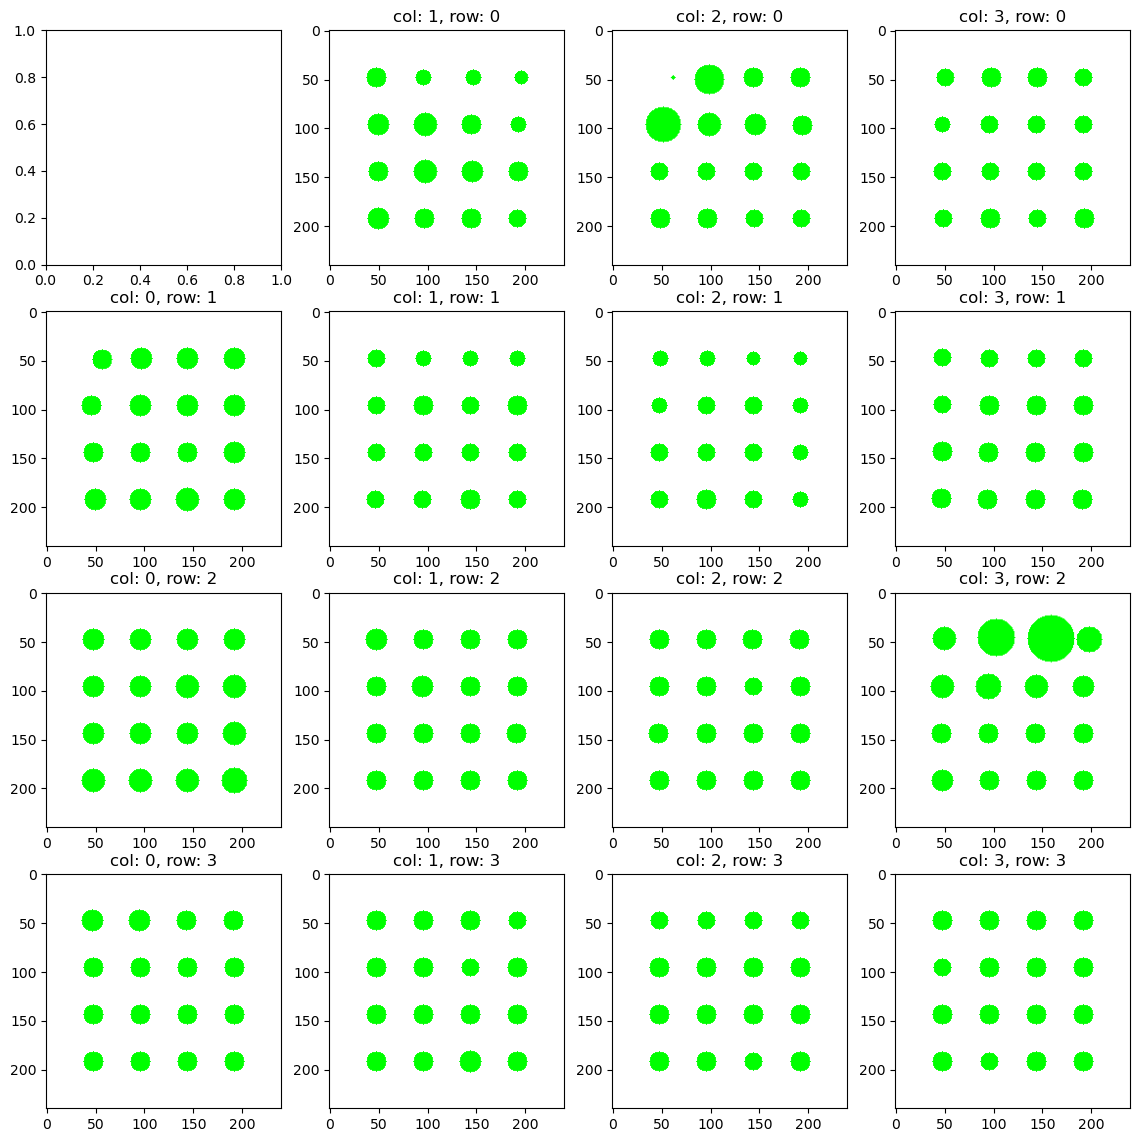

In [82]:
# Plot the tactile image and the actual sensor values
TACTILE_ID = 1400
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(14,14))
for column_id in range(4):
    for row_id in range(4):
        if column_id + row_id > 0:
            plot_tactile_sensor(
                ax = axs[row_id, column_id],
                sensor_values = tactile_values[TACTILE_ID, column_id*4+row_id-1],
                title='col: {}, row: {}'.format(column_id, row_id)
            )


tensor(425.7000) tensor(-124.1900) tensor(301.5100)


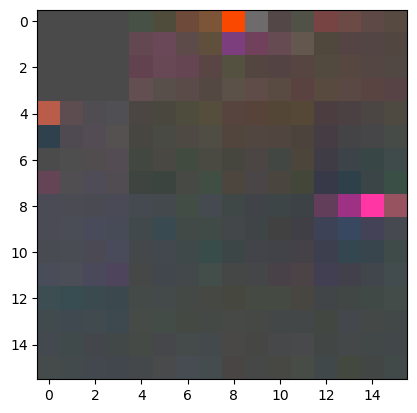

In [83]:
tactile_image = get_whole_tactile_image(tactile_values[TACTILE_ID])
plot_tactile_image(tactile_image)


In [84]:
from copy import deepcopy
import glob
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import torch
import torchvision.transforms as T 

from torchvision.datasets.folder import default_loader as loader 
from torch.utils import data
from tqdm import tqdm
from omegaconf import DictConfig, OmegaConf

In [145]:
class TactileWholeDataset(data.Dataset):
    # Dataset to give tactile values for two fingers and tip positions for two fingers
    def __init__(
        self,
        data_path,
        fingertip_stats = None
    ):
        super().__init__()

        # Get the demo directories 
        self.roots = glob.glob(f'{data_path}/demonstration_*')
        self.roots = sorted(self.roots)

        # Get the indices
        self.tactile_indices = []
        self.tactile_values = []
        self.tactile_image_size = 16 # This is set for now
        self.allegro_indices = []
        self.allegro_tip_positions = [] # Will hold 3 positions for 2 fingers (index, middle)
        self.allegro_action_indices = []
        self.allegro_actions = []

        # Load the index values 
        for root in self.roots:
            # Load the indices
            with open(os.path.join(root, 'tactile_indices.pkl'), 'rb') as f:
                self.tactile_indices += pickle.load(f)
            with open(os.path.join(root, 'allegro_indices.pkl'), 'rb') as f:
                self.allegro_indices += pickle.load(f)
            with open(os.path.join(root, 'allegro_action_indices.pkl'), 'rb') as f:
                self.allegro_action_indices += pickle.load(f)

            # Load the data
            with h5py.File(os.path.join(root, 'allegro_fingertip_states.h5'), 'r') as f:
                self.allegro_tip_positions.append(f['positions'][()])
            with h5py.File(os.path.join(root, 'allegro_commanded_joint_states.h5'), 'r') as f:
                self.allegro_actions.append(f['positions'][()]) # Positions are to be learned - since this is a position control
            with h5py.File(os.path.join(root, 'touch_sensor_values.h5'), 'r') as f:
                self.tactile_values.append(f['sensor_values'][()])

        self.resize_transform = T.Resize((self.tactile_image_size, self.tactile_image_size))

        if fingertip_stats is None:
            self.fingertip_mean, self.fingertip_std = self._calculate_fingertip_mean_std()
        else:
            self.fingertip_mean, self.fingertip_std = fingertip_stats[0], fingertip_stats[1]

        # self._calculate_tactile_image_mean_std() # We need to print it out for the first time

    def _calculate_fingertip_mean_std(self):
        num_fingers = 4 
        all_fingertip_pos = np.zeros((len(self.allegro_indices),num_fingers,3)) # 3 for each finger - we will have positions for each axes
        for id in range(len(self.allegro_indices)):
            demo_id, allegro_id = self.allegro_indices[id]
            # Traverse through each finger
            for finger_id in range(num_fingers):
                all_fingertip_pos[id,finger_id,:] = self.allegro_tip_positions[demo_id][allegro_id][finger_id*3:(finger_id+1)*3]

        allegro_mean = all_fingertip_pos.mean(axis=(0,1))
        allegro_std = all_fingertip_pos.std(axis=(0,1))
        print('allegro_mean: {}, allegro_std: {}'.format(allegro_mean, allegro_std))

        return allegro_mean, allegro_std

    def _calculate_tactile_image_mean_std(self):
        # Will traverse through all iamges and get mean, stds per channel
        print('calculating the mean and std')
        pbar = tqdm(total=len(self.tactile_values))
        tactile_images = np.zeros((len(self.tactile_indices),
                                   3,
                                   self.tactile_image_size,
                                   self.tactile_image_size))
        for id in range(len(self.tactile_values)):
            demo_id, tactile_id = self.tactile_indices[id]
            tactile_value = self.tactile_values[demo_id][tactile_id]
            tactile_images[id,:] = self._get_tactile_image(tactile_value)
            pbar.update(1)

        tactile_mean = tactile_images.mean(axis=(0,2,3))
        tactile_std = tactile_images.std(axis=(0,2,3))
        pbar.close()
        print('tactile_mean: {}, tactile_std: {}'.format(tactile_mean, tactile_std))
        return tactile_mean, tactile_std

    # Method to transform tactile_value to tactile image
    def _get_tactile_image(self, tactile_values): 
        # tactile_values: (15,16,3)
        # turn it into 16,16,3 by concatenating 0z
        tactile_image = torch.FloatTensor(tactile_values)
        tactile_image = F.pad(tactile_image, (0,0,0,0,1,0), 'constant', 0)
        # reshape it to 4x4
        tactile_image = tactile_image.view(16,4,4,3)

        # concat for it have its proper shape
        tactile_image = torch.concat([
            torch.concat([tactile_image[i*4+j] for j in range(4)], dim=0)
            for i in range(4)
        ], dim=1)

        tactile_image = torch.permute(tactile_image, (2,0,1))

        return self.resize_transform(tactile_image)

    def __len__(self):
        return len(self.tactile_indices)

    def __getitem__(self, index):
        demo_id, tactile_id = self.tactile_indices[index]
        _, allegro_id = self.allegro_indices[index]
        _, allegro_action_id = self.allegro_action_indices[index]

        # Get allegro values 
        allegro_tip_position = self.allegro_tip_positions[demo_id][allegro_id]
        allegro_tip_position = (allegro_tip_position - np.tile(self.fingertip_mean, 4)) / np.tile(self.fingertip_std, 4)
        allegro_action = self.allegro_actions[demo_id][allegro_action_id]

        # Get tactile image
        tactile_value = self.tactile_values[demo_id][tactile_id]
        tactile_image = self._get_tactile_image(tactile_value) # Will be returned without normalizing it - since it will be normalized

        return tactile_image, allegro_tip_position, allegro_action

    def getitem(self, index):
        return self.__getitem__(index)

In [146]:
dataset = TactileWholeDataset(
    data_path = '/home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting',
    fingertip_stats = [
        [0.07979609, 0.02479117, 0.04321017], # means
        [0.02117946, 0.05739853, 0.07401023] # stds
    ]
)
dataloader = DataLoader(
    dataset, 
    batch_size = 32,
    shuffle = True,
    num_workers = 4,
    pin_memory = True,
)

In [147]:
class TactileWholeImageEncoder(nn.Module):
    def __init__(
        self,
        in_channels,
        out_dim # Final dimension of the representation
    ):
        super().__init__()
        self.out_dim = out_dim
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=64, kernel_size=3),
            nn.ReLU(),
            # PrintSize(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3),
            nn.ReLU(),
            # PrintSize(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            # PrintSize(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3),
            nn.ReLU()
            # PrintSize()
        )
        self.linear = nn.Linear(in_features=16*8*8, out_features=out_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.model(x)
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = self.linear(x)
        return self.relu(x)

In [148]:
from tactile_learning.models.ssl_wrappers.byol import BYOL
from torch.optim import Adam
from torch.utils.data import DataLoader
from tactile_learning.utils.augmentations import get_tactile_augmentations
from tactile_learning.models.custom import PrintSize

# img_means = [0.07979609, 0.02479117, 0.04321017]
# img_stds = [0.02117946, 0.05739853, 0.07401023]
img_means = [ 1.73514235e-04, -5.94937459e-05, 1.10546453e-04]
img_stds = [0.03470643, 0.03266872, 0.05792245]

image_size = 16
augment_fn = get_tactile_augmentations(
    img_means,
    img_stds,
    img_size=(image_size, image_size)
) # One augment_fn is enough (since it will be the same as augment2)
learner = BYOL(
    net = TactileWholeImageEncoder(3, 64), 
    image_size = image_size,
    augment_fn = augment_fn
)
optimizer = Adam(
    learner.parameters(),
    lr = 1e-2,
    weight_decay = 1e-5
)



In [149]:

batch = next(iter(dataloader))
# print(batch.shape)

pbar = tqdm(total=len(dataloader))

def train_one_epoch(earner, dataloader, optimizer):
    learner.train()
    total_train_loss = 0

    for batch in tqdm(dataloader):
        tactile_image, _, _ = batch
        optimizer.zero_grad()
        # input_data = torch.cat(input_images, dim = 1).to(configs.device)

        # print('input_images.shap: {}'.format(input_images.shape))
        loss = learner(tactile_image) 

        loss.backward()
        optimizer.step()
        learner.update_moving_average()

        total_train_loss += loss.item()
        pbar.set_description(f'Train Loss: {loss.item()}')
        pbar.update(1)

    average_train_loss = total_train_loss / len(dataloader)
    return average_train_loss 

average_loss = train_one_epoch(learner, dataloader, optimizer)

Train Loss: 0.002317085862159729:  60%|█████▉    | 1353/2259 [14:52<07:30,  2.01it/s] 

In [140]:
batch[2].shape

torch.Size([32, 16])